In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from os import path

In [3]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: both


In [4]:
# Prompt user for type of analsyis
while (True):
    options = ["Bacillariophyceae", "Dinoflagellata", "Haptophyta",
               "other than diatoms, dinoflagellates, or haptophytes", "All"]
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    analysis_type = int(input("Please enter a number (1-5) for the type analysis: "))
    if (analysis_type in range(1,6)):
        analysis_type = str(options[analysis_type-1])
        break
    print("Invalid argument")

1: Bacillariophyceae
2: Dinoflagellata
3: Haptophyta
4: other than diatoms, dinoflagellates, or haptophytes
5: All
Please enter a number (1-5) for the type analysis: 1


In [5]:
# Ask user if running analysis on a new cruise
while (True):
    reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Are you running the analysis on a new cruise? (y/n): n


In [6]:
# first call bash script to get necessary file inputs
# for geographic script, choose query_samples for underway gps data alignment as input script
# for worms script, choose names_ids.csv for input script
# only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
if ( not reply[0] != 'y' or not (path.exists('resolved_auto.csv') 
        and path.exists('resolved_manual.csv' and path.exists('comparison.csv')))):
    subprocess.call(['./exec.sh', reply[0]])

In [7]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['permalink', 'namespace_manual', 'worms_higher_order_manual', 'Biovolume', 'MajorAxisLength']
elif (dataset_type == 'automated'):
    columns = ['permalink', 'namespace_automated', 'Biovolume', 'MajorAxisLength']
else:
    columns = ['permalink', 'namespace_manual', 'namespace_automated', 'worms_higher_order_manual', 
               'Biovolume', 'MajorAxisLength']

In [8]:
# read in level 1_b file
all_rois = pd.read_csv('level_1b.csv', usecols=columns)

In [9]:
'''# Prompt user for type of analsyis- Prototyping (don't use for now)
while (True):
    analysis_type = str(input("Please enter 'species', 'higher ranks', or 'all' for the type analysis: "))
    # make case insenstive
    analsyis_type = analysis_type.lower()
    if (analysis_type == 'species' or analysis_type == 'higher ranks' or analysis_type == 'all'):
        break
    print("Invalid argument")
# Show drop down list if 'species' is chosen
if (analysis_type == 'species'):
    higher_rank = 'worms_higher_order_{}'.format(dataset_type)
    all_species = set(all_rois.loc[all_rois[higher_rank].notna(), 
                                  'namespace_{}'.format(dataset_type)])
    print(all_species)'''

'# Prompt user for type of analsyis- Prototyping (don\'t use for now)\nwhile (True):\n    analysis_type = str(input("Please enter \'species\', \'higher ranks\', or \'all\' for the type analysis: "))\n    # make case insenstive\n    analsyis_type = analysis_type.lower()\n    if (analysis_type == \'species\' or analysis_type == \'higher ranks\' or analysis_type == \'all\'):\n        break\n    print("Invalid argument")\n# Show drop down list if \'species\' is chosen\nif (analysis_type == \'species\'):\n    higher_rank = \'worms_higher_order_{}\'.format(dataset_type)\n    all_species = set(all_rois.loc[all_rois[higher_rank].notna(), \n                                  \'namespace_{}\'.format(dataset_type)])\n    print(all_species)'

In [10]:
# prompt user to ask for desired size distribution, keep at 20 for now
threshold = input('Please enter minimum Major Axis Length to analyze (micrometers): ')
threshold = float(threshold)

Please enter minimum Major Axis Length to analyze (micrometers): 20


In [11]:
# get higher order data if dataset is automated
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    all_rois.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')
else:
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    all_rois.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    all_rois = pd.merge(all_rois, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')

In [12]:
# separate out roi id from permalink
all_rois['roi'] = all_rois['permalink']
all_rois.roi = all_rois.roi.str.slice(68, 74)
# gets rid of leading zeros
all_rois.roi = all_rois.roi.str.lstrip("0")
# cut permalink to just be permalink of sample
all_rois.permalink = all_rois.permalink.str.slice(0, 67)

In [13]:
# read in gps coordinates file
coords = pd.read_csv('comparison.csv', usecols=['pid', 'gps_furuno_latitude'])
# merge with all_rois based on smaple ids
all_rois = pd.merge(all_rois, coords, how='left', left_on='permalink', right_on='pid')

In [14]:
# first exclude abiotic particles
all_rois = all_rois[all_rois['alt_datasource'] != "OCB"]
# calculate total biovolume per sample
total = all_rois.groupby('permalink')['Biovolume'].sum().reset_index()
total.rename(columns={'Biovolume':'total_biovolume'}, inplace=True)
# merge 2 data frames based on sample_identifier
all_rois = pd.merge(all_rois, total, how='left', on='permalink')

In [15]:
# filter out rows below threshold
all_rois = all_rois[all_rois.MajorAxisLength > threshold]

In [16]:
# group by sample identifiers and higher ranks to calculate total biovolume per ranking
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = all_rois.groupby(
        ['permalink', 'worms_higher_order_automated'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    auto_samples['percent_biovolume'] = auto_samples['Biovolume']/auto_samples['total_biovolume']

    # manual data frame
    manual_samples = all_rois.groupby(
        ['permalink', 'worms_higher_order_manual'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    manual_samples['percent_biovolume'] = manual_samples['Biovolume']/manual_samples['total_biovolume']
else:
    all_rois = all_rois.groupby(
        ['permalink', 'worms_higher_order_{}'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    all_rois['percent_biovolume'] = all_rois['Biovolume']/all_rois['total_biovolume']

In [17]:
# filter out to only read user specified analysis_type
if (dataset_type == 'both'):
    if (analysis_type != 'All'):
        auto_samples = auto_samples[auto_samples['worms_higher_order_automated'] == analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['worms_higher_order_manual'] == analysis_type].reset_index()
else:
    if (analysis_type != 'All'):
        print(dataset_type)
        all_rois = samples[samples['worms_higher_order_{}'.format(dataset_type)] == analysis_type].reset_index()

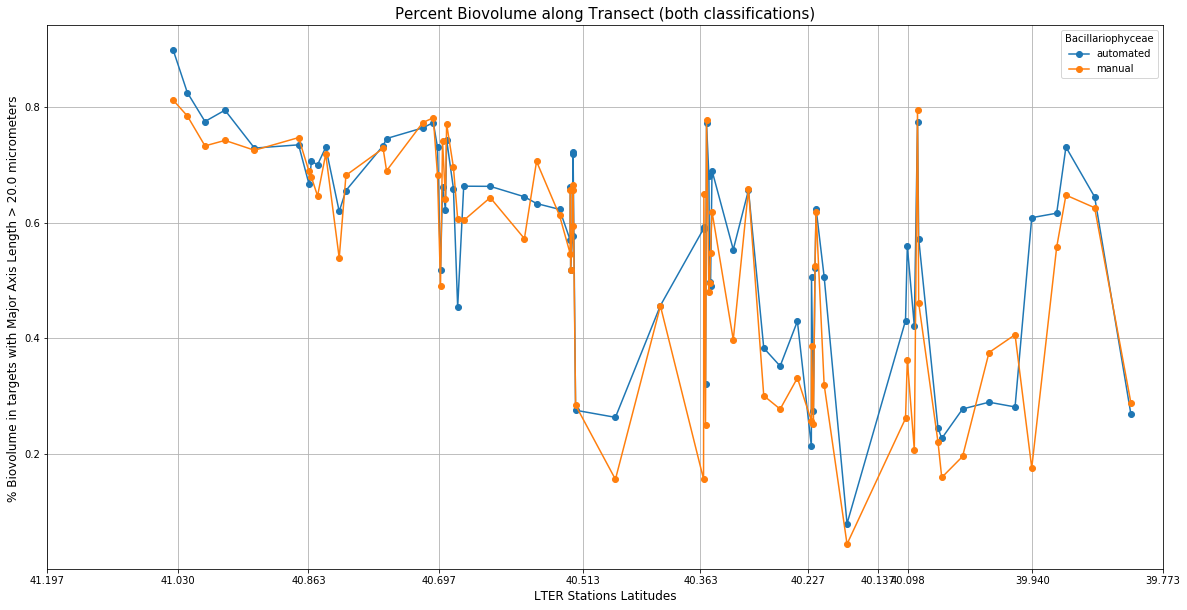

In [18]:
# take duplicate latitudes and add their concentrations together to make percent biovolume plot
fig, ax = plt.subplots(figsize=(20, 10))   
# use unstack()
if (dataset_type == 'both'): 
    rois = auto_samples.groupby(['gps_furuno_latitude','worms_higher_order_automated']).sum()['percent_biovolume']
    rois.unstack().plot(ax=ax, marker='o')
    rois = manual_samples.groupby(['gps_furuno_latitude','worms_higher_order_manual']).sum()['percent_biovolume']
    rois.unstack().plot(ax=ax, marker='o')
    L=plt.legend(title=analysis_type)
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    rois = all_rois.groupby(['gps_furuno_latitude','worms_higher_order_{}'.format(dataset_type)]).sum()['percent_biovolume']
    rois.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size=12)
plt.ylabel('% Biovolume in targets with Major Axis Length > {} micrometers '.format(threshold), size=12)
plt.title('Percent Biovolume along Transect ({} classifications)'.format(dataset_type), size=15)
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# invert x axis
ax.invert_xaxis()
plt.show()

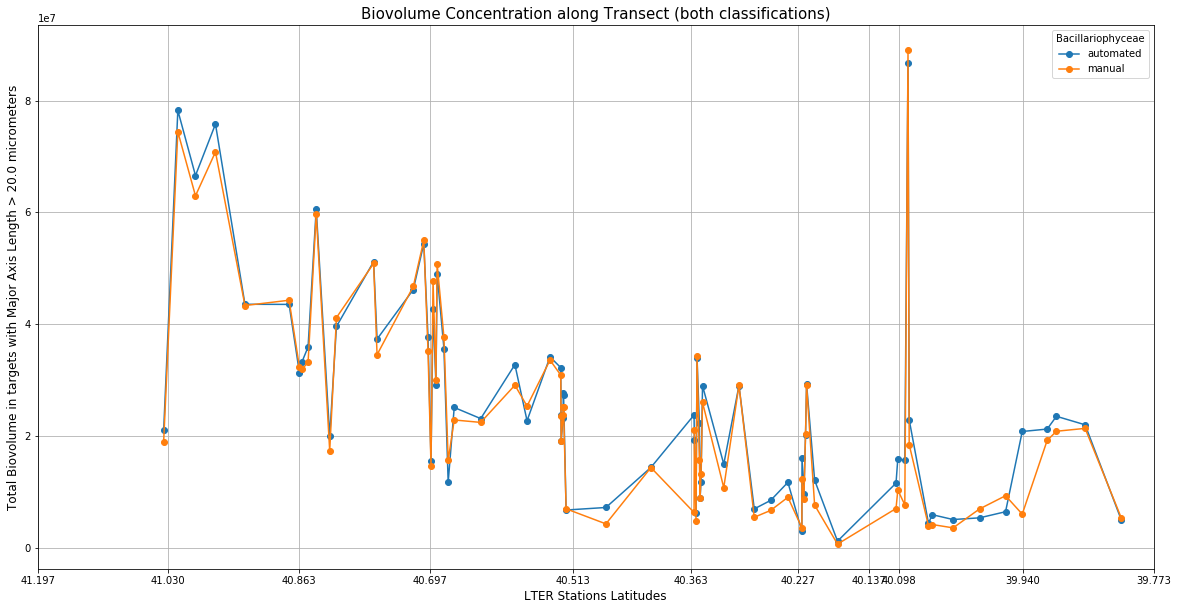

In [19]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(20, 10))
# use unstack()
if (dataset_type == 'both'): 
    rois = auto_samples.groupby(['gps_furuno_latitude','worms_higher_order_automated']).sum()['Biovolume']
    rois.unstack().plot(ax=ax, marker='o')
    rois = manual_samples.groupby(['gps_furuno_latitude','worms_higher_order_manual']).sum()['Biovolume']
    rois.unstack().plot(ax=ax, marker='o')
    L=plt.legend(title=analysis_type)
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    rois = all_rois.groupby(['gps_furuno_latitude','worms_higher_order_{}'.format(dataset_type)]).sum()['Biovolume']
    rois.unstack().plot(ax=ax, marker='o')
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size=12)
plt.ylabel('Total Biovolume in targets with Major Axis Length > {} micrometers'.format(threshold), size=12)
plt.title('Biovolume Concentration along Transect ({} classifications)'.format(dataset_type), size=15)
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# invert x axis
ax.invert_xaxis()
plt.show()